# How have global CO2 emissions changed over time?

* Our aim is to conduct a time series analysis of carbon emissions over past years and on the basis of this forecast future CO2 emissions.
* Period under study = 2000 to 2017
* We first check for the stationarity of the data, then we use techniques to eliminate the same. Once stationarity is removed, we find optimal no. of lags to be used with the help of ACF and PACF graphs. We then fit ARIMA model and find that our model is very well fitted and RSS is minimised. We later use this model to forecast monthly CO2 emissions for the next 10 years.

__Importing libraries__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams ['figure.figsize'] = 15,10

__Importing CO2 Dataset__

In [3]:
dataset = pd.read_excel('co2.xlsx')
dataset.head()


,Months,CO2
0,2000-01-01,369.29
1,2000-02-01,369.54
2,2000-03-01,370.60
3,2000-04-01,371.82
4,2000-05-01,371.58


__Parsing string to datetime type__

In [4]:
dataset['Months']= pd.to_datetime(dataset['Months'], infer_datetime_format = True)
indexedDataset = dataset.set_index(['Months'])

In [5]:
from datetime import datetime
indexedDataset.head()

,CO2
Months,
2000-01-01,369.29
2000-02-01,369.54
2000-03-01,370.60
2000-04-01,371.82
2000-05-01,371.58


In [6]:
indexedDataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 2000-01-01 to 2017-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO2     216 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


In [7]:
indexedDataset.describe()

,CO2
count,216.000000
mean,387.108704
std,11.289518
min,367.000000
25%,377.675000
50%,386.530000
75%,396.320000
max,409.650000


In [8]:
indexedDataset.shape

(216, 1)

__Plotting and visualisation__

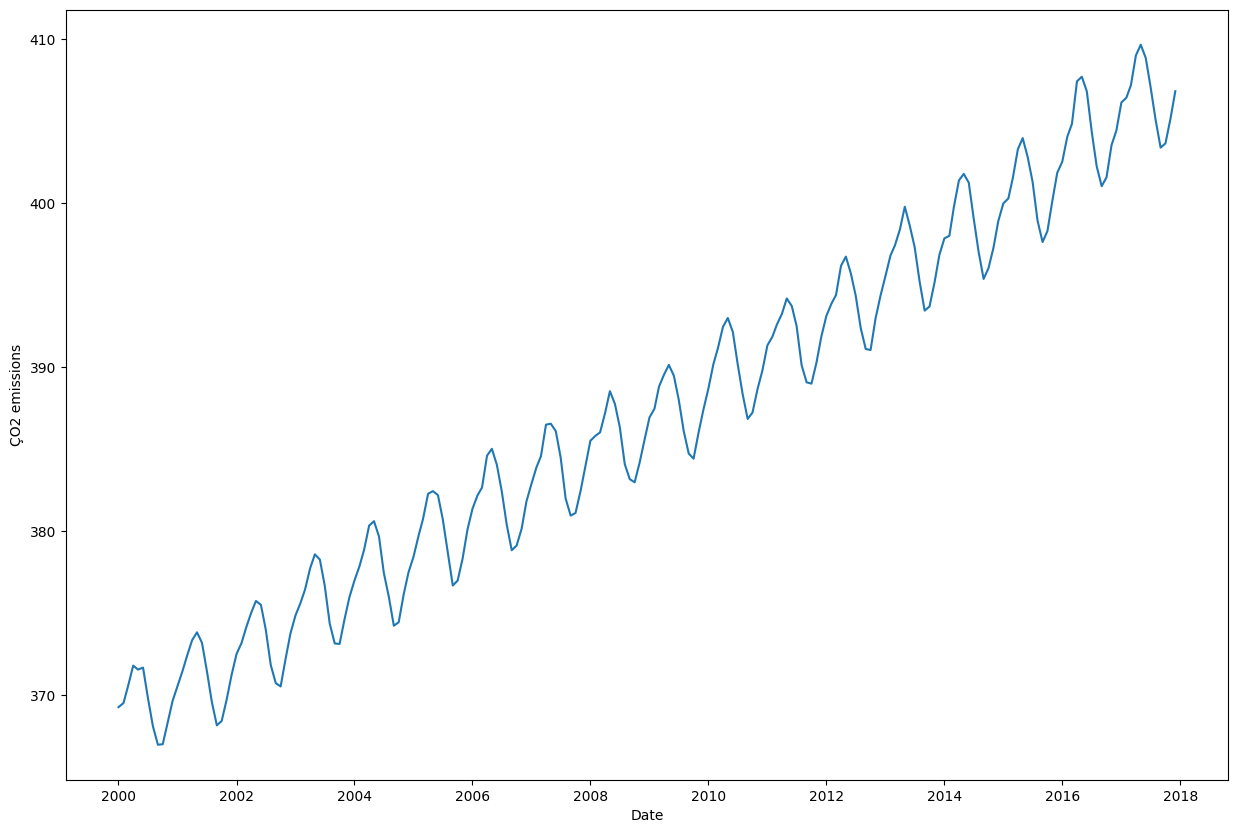

In [9]:
plt.xlabel('Date')
plt.ylabel('ÇO2 emissions')
plt.plot(indexedDataset)

_We can see an upward trend in CO2 emissions overtime and data is not stationary since mean is varying at different points of time._

__Tests for checking stationarity of data__

In [10]:
#determining rolling statistics
rolmean = indexedDataset.rolling(window=12).mean()
rolstd = indexedDataset.rolling(window=12).std()
print(rolmean, rolstd)

                   CO2
Months                
2000-01-01         NaN
2000-02-01         NaN
2000-03-01         NaN
2000-04-01         NaN
2000-05-01         NaN
...                ...
2017-08-01  405.825833
2017-09-01  406.021667
2017-10-01  406.194167
2017-11-01  406.328333
2017-12-01  406.528333

[216 rows x 1 columns]                  CO2
Months              
2000-01-01       NaN
2000-02-01       NaN
2000-03-01       NaN
2000-04-01       NaN
2000-05-01       NaN
...              ...
2017-08-01  2.804910
2017-09-01  2.505713
2017-10-01  2.227157
2017-11-01  2.096750
2017-12-01  2.010879

[216 rows x 1 columns]


_We have taken window = 12 since we have monthly data._

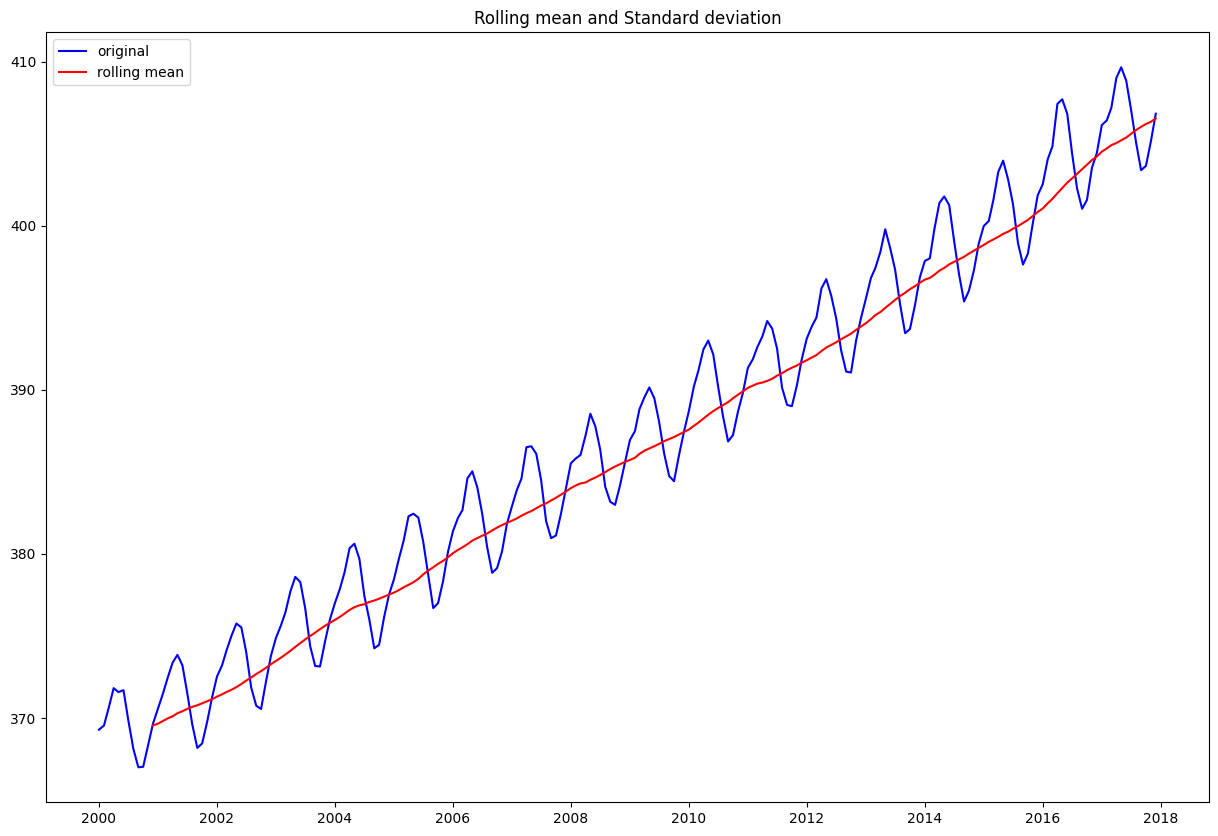

In [11]:
#plot rolling statistics
orig = plt.plot(indexedDataset, color= 'blue', label = 'original')
mean = plt.plot(rolmean, color= 'red', label = 'rolling mean')
plt.legend(loc='best')
plt.title('Rolling mean and Standard deviation')
plt.show(block=False)

_We see that rolling mean is not constant which indicates that data is not stationary._

In [12]:
# Dickey-fuller test

from statsmodels.tsa.stattools import adfuller

print('Results of Dickey fuller test:')
dftest = adfuller(indexedDataset['CO2'], autolag = 'AIC')


dfoutput = pd.Series(dftest[0:4], index = ['test statistic', 'p-value', '#lags used', 'no. of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value

print(dfoutput)

Results of Dickey fuller test:
test statistic                1.564608
p-value                       0.997747
#lags used                   13.000000
no. of observations used    202.000000
critical value (1%)          -3.463144
critical value (5%)          -2.875957
critical value (10%)         -2.574455
dtype: float64


_AIC is Akaike's information criterion. P-value is very high, thus we fail to reject null hypthosis : model is non-stationary. Thus, we first need to remove non-stationarity to implement ARIMA model._

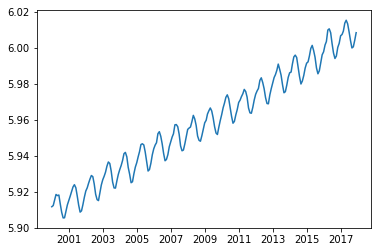

In [12]:
#estimating the trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

_We have taken the log of indexed dataset and plotted a line graph. Here, as compared to previous graph the y axis values get changed while the trend remains the same._

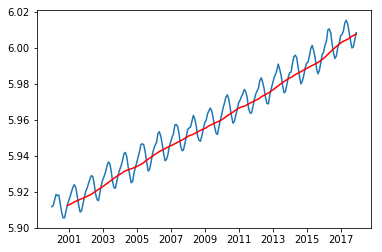

In [13]:
#calculating moving average with log transformed data
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

_Again we see that still our data is not stationary as there still exist an upward trend._

__Method 1 to make data stationary : Demeaning/Detrending__

In [14]:
datasetlogscaleminusmovingaverage = indexedDataset_logScale - movingAverage
datasetlogscaleminusmovingaverage.head()

,CO2
Months,
2000-01-01,NaN
2000-02-01,NaN
2000-03-01,NaN
2000-04-01,NaN
2000-05-01,NaN


_We define a new dataset named 'datasetlogscaleminusmovingaverage' by subtracting moving average from log transformed values of CO2 emissions._

In [15]:
#removing nan values
datasetlogscaleminusmovingaverage.dropna(inplace= True)
datasetlogscaleminusmovingaverage.head()

,CO2
Months,
2000-12-01,0.000337
2001-01-01,0.002529
2001-02-01,0.004566
2001-03-01,0.006629
2001-04-01,0.008803


__Defining a function for checking stationarity__

In [16]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #determining rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #plot rolling statistics
    orig = plt.plot(timeseries, color= 'blue', label = 'Original')
    mean = plt.plot(rolmean, color= 'red', label = 'Rolling mean')
    std = plt.plot(rolstd, color= 'black', label = 'Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean and Standard deviation')
    plt.show(block=False)
    
    #perform dickey-fuller test
    print('Results of Dickey fuller test:')
    dftest = adfuller(timeseries['CO2'], autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['test statistic', 'p-value', '#lags used', 'no. of observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)'%key]= value
    print(dfoutput)
    

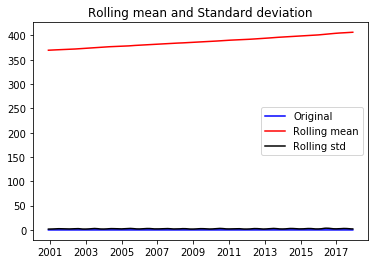

Results of Dickey fuller test:
test statistic               -4.279699
p-value                       0.000482
#lags used                   14.000000
no. of observations used    190.000000
Critical value (1%)          -3.465244
Critical value (5%)          -2.876875
Critical value (10%)         -2.574945
dtype: float64


In [17]:
#checking stationarity of our newly created dataset - 'datasetlogscaleminusmovingaverage'
test_stationarity(datasetlogscaleminusmovingaverage)

_H0: Yt is non-stationary_

_H1: Yt is stationary_

_Since critical value > test statistic or p-value is very low, we are able to reject null hypothesis. Hence, now data is stationary._




C:\Users\Divya\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


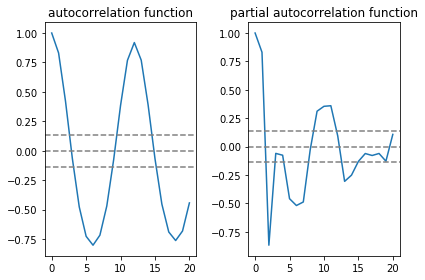

In [18]:
from statsmodels.tsa.stattools import acf,pacf

lag_acf = acf(datasetlogscaleminusmovingaverage, nlags=20)
lag_pacf = pacf(datasetlogscaleminusmovingaverage, nlags=20, method='ols')

#plot acf
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle= '--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetlogscaleminusmovingaverage)), linestyle= '--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetlogscaleminusmovingaverage)), linestyle= '--', color='gray')
plt.title('autocorrelation function')

#plot pacf
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle= '--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetlogscaleminusmovingaverage)), linestyle= '--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetlogscaleminusmovingaverage)), linestyle= '--', color='gray')
plt.title('partial autocorrelation function')
plt.tight_layout()

_In order to calculate value of p and q, we need to construct PACF and ACF graphs respectively. Value of p and q is determined where the graph drops to zero for the first time. This gives p=2 and q=3._

__Method 2 to make data stationary - first differencing__

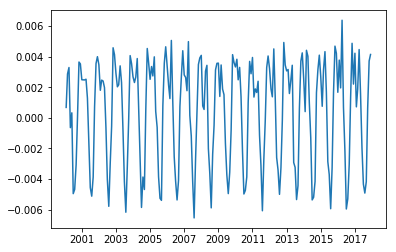

In [19]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

_We define a new dataset named 'datasetLogDiffShifting' by subtracting preceding log transformed values of CO2 emissions._

Generic formula is y(t)'= y(t) - y(t-1)

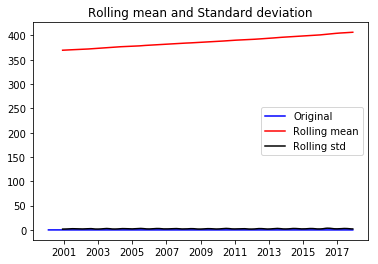

Results of Dickey fuller test:
test statistic               -4.597302
p-value                       0.000131
#lags used                   12.000000
no. of observations used    202.000000
Critical value (1%)          -3.463144
Critical value (5%)          -2.875957
Critical value (10%)         -2.574455
dtype: float64


In [20]:
#removing nan values
datasetLogDiffShifting.dropna(inplace= True)
test_stationarity(datasetLogDiffShifting)

_We find that first differencing gives us the best results with very low p-value and almost removes all the stationarity in the data._

C:\Users\Divya\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


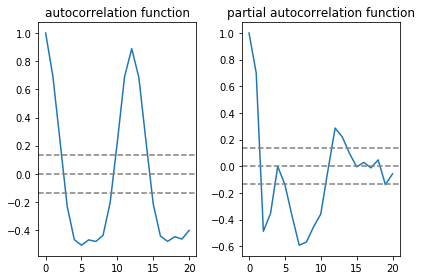

In [21]:
from statsmodels.tsa.stattools import acf,pacf

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#plot acf
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle= '--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle= '--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle= '--', color='gray')
plt.title('autocorrelation function')

#plot pacf
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle= '--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle= '--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle= '--', color='gray')
plt.title('partial autocorrelation function')
plt.tight_layout()

_In order to calculate value of p and q, we need to construct PACF and ACF graphs respectively. Value of p and q is determined where the graph drops to zero for the first time. This gives p=2, d=1 and q=3._

C:\Users\Divya\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Divya\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting ARIMA model


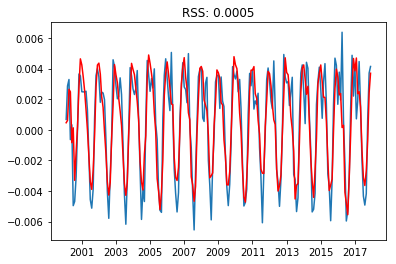

In [22]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(indexedDataset_logScale, order=(2,1,3))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues- datasetLogDiffShifting['CO2'])**2))
print('Plotting ARIMA model')

In [38]:
ar_coef, ma_coef = results_ARIMA.arparams, results_ARIMA.maparams
print(ar_coef, ma_coef)

[ 1.69706403 -0.96571102] [-1.4738959   0.24199528  0.34857459]


In [40]:
resid = results_ARIMA.resid
print(resid)

Months
2000-02-01    0.000218
2000-03-01    0.002256
2000-04-01    0.000641
2000-05-01   -0.003128
2000-06-01    0.001167
                ...   
2017-08-01   -0.001281
2017-09-01   -0.001506
2017-10-01    0.001376
2017-11-01    0.001294
2017-12-01    0.000442
Length: 215, dtype: float64


In [41]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                  215
Model:                 ARIMA(2, 1, 3)   Log Likelihood                1086.555
Method:                       css-mle   S.D. of innovations              0.002
Date:                Thu, 24 Oct 2019   AIC                          -2159.110
Time:                        10:46:15   BIC                          -2135.516
Sample:                    02-01-2000   HQIC                         -2149.577
                         - 12-01-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0005   4.52e-05     10.154      0.000       0.000       0.001
ar.L1.D.CO2     1.6971      0.016    104.826      0.000       1.665       1.729
ar.L2.D.CO2    -0.9657      0.016    -61.034    

WOW, Our model is well fitted.

In [23]:
#converting fitted values into a series format
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Months
2000-02-01    0.000459
2000-03-01    0.000608
2000-04-01    0.002645
2000-05-01    0.002482
2000-06-01   -0.000844
dtype: float64

In [24]:
#converting to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Months
2000-02-01    0.000459
2000-03-01    0.001067
2000-04-01    0.003712
2000-05-01    0.006195
2000-06-01    0.005351
dtype: float64

In [25]:
#predicting fitted values
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['CO2'].iloc[0], index = indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value = 0)
predictions_ARIMA_log.head()

Months
2000-01-01    5.911582
2000-02-01    5.912041
2000-03-01    5.912649
2000-04-01    5.915294
2000-05-01    5.917777
dtype: float64

_The above values are in log normalised thus we need to convert them back to original form by taking exponential._

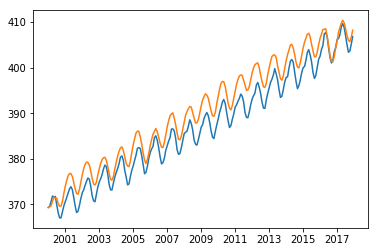

In [26]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

_Orange line is the model that we have fitted and blue line is the prediction. They both follow the same pattern but magnitude is different._

In [27]:
indexedDataset_logScale

,CO2
Months,
2000-01-01,5.911582
2000-02-01,5.912259
2000-03-01,5.915123
2000-04-01,5.918410
2000-05-01,5.917764
...,...
2017-08-01,6.004060
2017-09-01,5.999879
2017-10-01,6.000523


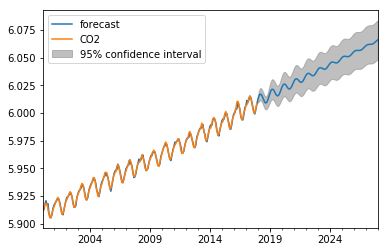

In [28]:
#forecasting CO2 emissions for next 10 years
results_ARIMA.plot_predict(1,336)
x= results_ARIMA.forecast(steps=120)


_We want monthly prediction for next 10 years, that is why steps = 12*10_

In the graph, blue line gives the forecasted values and the grey shaded region is the confidence level. No matter what happens, the actual value will not exceed the confidence level.

In [29]:
#log value of future CO2 emissions
x[0]

array([6.01207655, 6.01505035, 6.0167956 , 6.01700885, 6.01580859,
       6.013689  , 6.01137429, 6.00961624, 6.00899133, 6.00975185,
       6.01176923, 6.01458169, 6.01752966, 6.01993979, 6.02130632,
       6.02142117, 6.02041968, 6.01873242, 6.01695946, 6.01570329,
       6.01540692, 6.01624032, 6.01806413, 6.02047768, 6.02293562,
       6.02489938, 6.02598159, 6.02604503, 6.02523083, 6.02391109,
       6.02258095, 6.02172136, 6.02167037, 6.02253723, 6.02418084,
       6.02625627, 6.02831443, 6.02992625, 6.03079728, 6.03084219,
       6.03020051, 6.02919141, 6.02822186, 6.02767422, 6.02780442,
       6.02867749, 6.03015667, 6.03194707, 6.0336803 , 6.03501594,
       6.03573207, 6.03578082, 6.03529523, 6.03454734, 6.03387032,
       6.03356689, 6.033829  , 6.03469012, 6.03602163, 6.03757296,
       6.03904307, 6.04016306, 6.04076733, 6.04083448, 6.04048815,
       6.03995882, 6.03951823, 6.03940497, 6.03976149, 6.04059918,
       6.04179975, 6.04315149, 6.04440934, 6.04536187, 6.04588

In [30]:
len(x[0])

120

In [31]:
#absolute value of future CO2 emissions in ppp
future_prediction = np.exp(x[0])
print(future_prediction)

[408.33035872 409.54645783 410.26184605 410.34934245 409.85711228
 408.98930322 408.04370443 407.32697503 407.07251209 407.38221454
 408.20489126 409.35456603 410.56311148 411.55381714 412.11660101
 412.16393624 411.75136196 411.05721744 410.32907326 409.81395374
 409.69251595 410.03409739 410.78260261 411.77524491 412.78860977
 413.60002184 414.04786909 414.07413442 413.73713394 413.19146854
 412.64222995 412.28767949 412.26666068 412.62419166 413.30294121
 414.16161524 415.01490315 415.68437089 416.04660362 416.06528918
 415.79839081 415.37902245 414.97648613 414.74929233 414.8032943
 415.16560461 415.78016601 416.52524622 417.24780281 417.80546779
 418.10478054 418.12516315 417.92217544 417.60973194 417.32709791
 417.20048504 417.30985428 417.66936326 418.22586484 418.87517322
 419.4914177  419.96150937 420.21535473 420.24357258 420.09805501
 419.87574423 419.69079301 419.64325917 419.79289826 420.14470007
 420.64941602 421.21841051 421.74857474 422.1504924  422.37219477
 422.412075

In [32]:
len(future_prediction)

120

In [33]:
#exporting predictions to a csv file
pd.DataFrame(future_prediction).to_csv("co2prediction.csv")